# Analyse des traces électromagnétiques
Nous allons analyser les traces collectées sur l'appareil à attaquer. En émettant des hypothèses de clés et en les testant sur les traces, nous allons pouvoir déterminer la clé utilisée pour chiffrer les données.

L'algorithme visée est l'AES-128. Il est basé sur 10 tours de chiffrement des données. Chaque tour réalise 3 opérations : 
- une substitution de bits (S-Box)
- un décalage de bits (ShiftRows)
- une multiplication de bits (MixColumns)

Dans notre cas, nous allons partir des textes chiffrés pour remonter l'algorithme sur le dernier tour et ainsi trouver la clé.

Voici un schéma qui illustre l'attaque :\
***Insérer l'image du schéma***

In [1]:
directory = 'TRACES_DATA_CONVERTED';
load('TRACES_DATA_CONVERTED\keys.mat')
load('TRACES_DATA_CONVERTED\pti.mat')
load('TRACES_DATA_CONVERTED\cto.mat')
load('TRACES_DATA_CONVERTED\traces.mat')

disp('Tailles des matrices :')
disp(['keys : ' num2str(size(keys))])
disp(['pti : ' num2str(size(pti))])
disp(['cto : ' num2str(size(cto))])
disp(['traces : ' num2str(size(traces))])

Tailles des matrices :
keys : 20000     16
pti : 20000     16
cto : 20000     16
traces : 20000   4000



# Affichage de la moyenne des traces
On trace la moyenne des traces sur un graphique. On voit que l'on obtient 12 pics. Or, on sait que l'AES-128 est sur 10 tours. 
Cette différence vient d'une mauvaise implémentation matérielle. C'est notamment pour cela que l'on attaque par le bas de l'algorithme.
=> On attaque sur le 10e round.

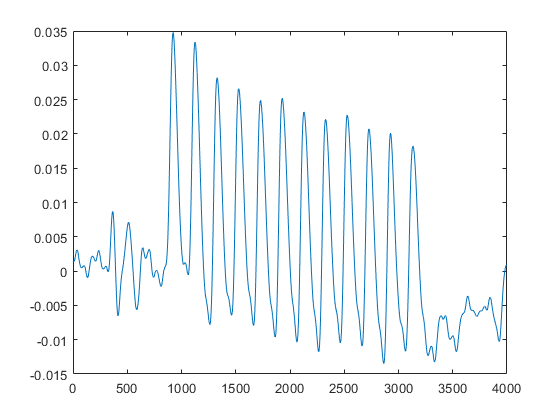

In [2]:
traces_mean = mean(traces);
figure
plot(traces_mean)

## Analyse du graphique
On constate ici que le 10e round est entre 3000 et 3500. On peut donc réduire l'étude à cette plage.

## Objectif
On cherche à inverser les fonctions de chiffrement. 
Notamment, on cherche à inverser la S_Box.

Etape 1 : on cherche les hypothèses sur les clés => $w_{10}$ \
Etape 2 : on crée toutes les hypothèses pour les sous-clés => $Z$ de dimension $[N_t \times 256]$ \
Etape 3 : on remonte les boîtes de l'algo (ShiftRow et SBox) \
Etape 4 : on fait une corrélation entre les traces et les hypothèses

Calcul de $w_{10}$ à partir de la clé fourni dans les fichiers des traces.

In [3]:
keys4x4 = reshape(keys(1, :), [4 4])
all_w = keysched2(uint32(keys4x4));

all_w;
w10 = all_w(:, :, 11) % point d'arrivée. Objectif de l'algorithme



keys4x4 =

    76   181   144   132
   140   201    87    25
   223     6   236    58
    35   247   113   103


w10 =

  4x4 uint32 matrix

    60    64    77    37
    71   214    56   251
    64   128     0   120
     1   146   185   176




Fonctions fournis par le professeur pour réaliser l'analyse.

In [4]:
shiftrow = [1, 6, 11, 16, 5, 10, 15, 4, 9, 14, 3, 8, 13, 2, 7, 12];
shiftrow = reshape(shiftrow, [4 4]);

SBox = [99, 124, 119, 123, 242, 107, 111, 197, 48, 1, 103, 43, 254, 215, 171, 118, 202, 130, 201, 125, 250, 89, 71, 240, 173, 212, 162, 175, 156, 164, 114, 192, 183, 253, 147, 38, 54, 63, 247, 204, 52, 165, 229, 241, 113, 216, 49, 21, 4, 199, 35, 195, 24, 150, 5, 154, 7, 18, 128, 226, 235, 39, 178, 117, 9, 131, 44, 26, 27, 110, 90, 160, 82, 59, 214, 179, 41, 227, 47, 132, 83, 209, 0, 237, 32, 252, 177, 91, 106, 203, 190, 57, 74, 76, 88, 207, 208, 239, 170, 251, 67, 77, 51, 133, 69, 249, 2, 127, 80, 60, 159, 168, 81, 163, 64, 143, 146, 157, 56, 245, 188, 182, 218, 33, 16, 255, 243, 210, 205, 12, 19, 236, 95, 151, 68, 23, 196, 167, 126, 61, 100, 93, 25, 115, 96, 129, 79, 220, 34, 42, 144, 136, 70, 238, 184, 20, 222, 94, 11, 219, 224, 50, 58, 10, 73, 6, 36, 92, 194, 211, 172, 98, 145, 149, 228, 121, 231, 200, 55, 109, 141, 213, 78, 169, 108, 86, 244, 234, 101, 122, 174, 8, 186, 120, 37, 46, 28, 166, 180, 198, 232, 221, 116, 31, 75, 189, 139, 138, 112, 62, 181, 102, 72, 3, 246, 14, 97, 53, 87, 185, 134, 193, 29, 158, 225, 248, 152, 17, 105, 217, 142, 148, 155, 30, 135, 233, 206, 85, 40, 223, 140, 161, 137, 13, 191, 230, 66, 104, 65, 153, 45, 15, 176, 84, 187, 22];

invSBox(SBox(1:256) + 1) = 0:255;
size(SBox)
size(invSBox)

Weight_Hamming_vect = [0 1 1 2 1 2 2 3 1 2 2 3 2 3 3 4 1 2 2 3 2 3 3 4 2 3 3 4 3 4 4 5 1 2 2 3 2 3 3 4 2 3 3 4 3 4 4 5 2 3 3 4 3 4 4 5 3 4 4 5 4 5 5 6 1 2 2 3 2 3 3 4 2 3 3 4 3 4 4 5 2 3 3 4 3 4 4 5 3 4 4 5 4 5 5 6 2 3 3 4 3 4 4 5 3 4 4 5 4 5 5 6 3 4 4 5 4 5 5 6 4 5 5 6 5 6 6 7 1 2 2 3 2 3 3 4 2 3 3 4 3 4 4 5 2 3 3 4 3 4 4 5 3 4 4 5 4 5 5 6 2 3 3 4 3 4 4 5 3 4 4 5 4 5 5 6 3 4 4 5 4 5 5 6 4 5 5 6 5 6 6 7 2 3 3 4 3 4 4 5 3 4 4 5 4 5 5 6 3 4 4 5 4 5 5 6 4 5 5 6 5 6 6 7 3 4 4 5 4 5 5 6 4 5 5 6 5 6 6 7 4 5 5 6 5 6 6 7 5 6 6 7 6 7 7 8];



ans =

     1   256


ans =

     1   256




# A faire
- Inversion du shiftrow (faire des tests ou à la main)
- Calcul des Zi (Z3 notamment)
- Comparaison de la corrélation entre les traces et les hypothèses (Zi) => on cherche à trouver le max de corrélation


Poids Hamming déjà fourni => table de correspondance entre vals et poids hamming
SBox-1 déjà fourni aussi => table de correspondance entre vals et vals inversées

In [5]:
hypothese = uint8(ones(size(cto, 1), 1) * (0:255));
size(hypothese)
cto_extended = uint8(single(cto(:, 1)) * ones(1, 256));
size(cto_extended)

Z1 = bitxor(cto_extended, hypothese);
Z1(1:10, 1:10);
size(Z1)


ans =

       20000         256


ans =

       20000         256


ans =

       20000         256




In [5]:
size(Z1)
size(Weight_Hamming_vect)
pt_attack1=Z1(Weight_Hamming_vect+1);
pt2=Weight_Hamming_vect(Z1+1);
% size(pt_attack1)
sum(pt_attack1);
% pt2=sum(pt2);


ans =

       20000         256


ans =

     1   256




In [6]:
Z3=invSBox(Z1+1);
size(Z3)
pt3=Weight_Hamming_vect(Z3+1);
size(pt3)


ans =

       20000         256


ans =

       20000         256




In [13]:
dh_13 = Weight_Hamming_vect(bitxor(uint8(Z3), uint8(Z1)) + 1);
dh_03 = Weight_Hamming_vect(bitxor(uint8(Z3), uint8(cto_extended)) + 1);
ph_3 = Weight_Hamming_vect(uint8(Z3) + 1);
size(dh_13)



ans =

       20000         256





ans =

     1   256




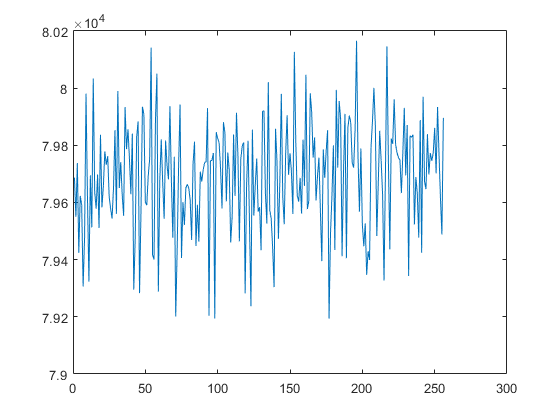

In [10]:
pt3_affichage = sum(pt3);
size(pt3_affichage)
plot(pt3_affichage)
% plot(pt3)

In [8]:
correlation = corr(single(dh_13), traces);
% corr(single(pt3), traces);
size(correlation)
% plot(0:size(correlation, 2) - 1, correlation(1:256, :));


ans =

         256        4000




## Affichage de la corrélation
On affiche la corrélation entre les traces et les hypothèses. On voit que la corrélation est maximale pour la courbe en rouge. Cela signifie que cette valeur est la plus probable pour la clé $w_{10}$.

Il est important que la différence entre les courbes bleues et celle rouge soit suffisamment grande pour bien s'assurer de la prédiction de la valeur de la clé.


ans =

     2




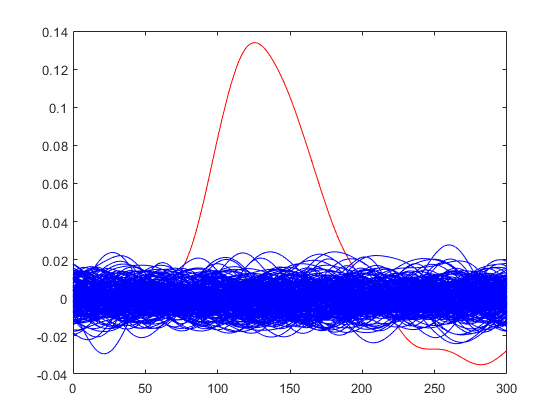

In [61]:
idxmin = 3000;
idxmax = 3300;
correlation = corr(single(dh_03), traces);
correlation = correlation(:,idxmin:idxmax);
[RK, IK] = sort(max(abs(correlation), [], 2), 'descend');
figure
plot((0:size(correlation, 2) - 1), correlation(IK(1), :), 'r')
hold on

if IK(1) == 1
    plot((0:size(correlation, 2) - 1), correlation(2:end, :), 'b')
else

    if IK(1) == 16
        plot((0:size(correlation, 2) - 1), correlation(1:end - 1, :), 'b')
    else
        plot((0:size(correlation, 2) - 1), correlation(1:IK(1) - 1, :), 'b')
        plot((0:size(correlation, 2) - 1), correlation(IK(1) + 1:end, :), 'b')
    end

end
IK(1)

# Programme complet - attaque par analyse EMA
Ci-dessous se trouve le programme complet qui est un assemblage de tous les éléments ci-dessus. Il permet de réaliser l'attaque par analyse EMA.
Le programme renvoie la clé trouvée lors de l'attaque.

## Note sur la distance de Hamming
Pour faire le bon calcul de distance de hamming, il faut comparer les bonnes valeurs entre elles. Ainsi, quand on commence avec la valeur $cto_{1,1}$, on doit la comparer avec la valeur $cto_{1,1}$ après passage dans l'algo. Ensuite, la valeur $cto_{2,1}$ sera comparée avec la valeur $cto_{2,4}$ après passage dans l'algo car on doit faire la comparaison des mêmes valeurs. (Fonctionnement du `shiftrow`)


<!-- Matrices de cto -->
Matrice de cto avant passage dans l'algo : 
$\begin{pmatrix}
\text{cto}_{1,1} & \text{cto}_{1,2} & \text{cto}_{1,3} & \text{cto}_{1,4} \\
\text{cto}_{2,1} & \text{cto}_{2,2} & \text{cto}_{2,3} & \text{cto}_{2,4} \\
\text{cto}_{3,1} & \text{cto}_{3,2} & \text{cto}_{3,3} & \text{cto}_{3,4} \\
\text{cto}_{4,1} & \text{cto}_{4,2} & \text{cto}_{4,3} & \text{cto}_{4,4} \\
\end{pmatrix}$

Matrice de cto après passage dans l'algo :
$\begin{pmatrix}
\text{cto}_{1,1} & \text{cto}_{1,2} & \text{cto}_{1,3} & \text{cto}_{1,4} \\
\text{cto}_{2,4} & \text{cto}_{2,1} & \text{cto}_{2,2} & \text{cto}_{2,3} \\
\text{cto}_{3,3} & \text{cto}_{3,4} & \text{cto}_{3,1} & \text{cto}_{3,2} \\
\text{cto}_{4,2} & \text{cto}_{4,3} & \text{cto}_{4,4} & \text{cto}_{4,1} \\
\end{pmatrix}$

Démonstration et tests de la fonction `circshift` pour réaliser le `shiftrow` :

In [57]:
line = 1:16;
line = reshape(line, [4 4]);
line

for i = 1:4

    disp(line(i, :))
    line(i, :) = circshift(line(i, :), i - 1);
    disp(line(i, :))
    line(i, :) = circshift(line(i, :), 1 - i);
    disp(line(i, :))

end

line



line =

     1     5     9    13
     2     6    10    14
     3     7    11    15
     4     8    12    16

     1     5     9    13

     1     5     9    13

     1     5     9    13

     2     6    10    14

    14     2     6    10

     2     6    10    14

     3     7    11    15

    11    15     3     7

     3     7    11    15

     4     8    12    16

     8    12    16     4

     4     8    12    16


line =

     1     5     9    13
     2     6    10    14
     3     7    11    15
     4     8    12    16




In [59]:
keys4x4 = reshape(keys(1, :), [4 4]);
all_w = keysched2(uint32(keys4x4));
w10 = all_w(:, :, 11) % point d'arrivée. Objectif de l'algorithme. (w10)

SBox = [99, 124, 119, 123, 242, 107, 111, 197, 48, 1, 103, 43, 254, 215, 171, 118, 202, 130, 201, 125, 250, 89, 71, 240, 173, 212, 162, 175, 156, 164, 114, 192, 183, 253, 147, 38, 54, 63, 247, 204, 52, 165, 229, 241, 113, 216, 49, 21, 4, 199, 35, 195, 24, 150, 5, 154, 7, 18, 128, 226, 235, 39, 178, 117, 9, 131, 44, 26, 27, 110, 90, 160, 82, 59, 214, 179, 41, 227, 47, 132, 83, 209, 0, 237, 32, 252, 177, 91, 106, 203, 190, 57, 74, 76, 88, 207, 208, 239, 170, 251, 67, 77, 51, 133, 69, 249, 2, 127, 80, 60, 159, 168, 81, 163, 64, 143, 146, 157, 56, 245, 188, 182, 218, 33, 16, 255, 243, 210, 205, 12, 19, 236, 95, 151, 68, 23, 196, 167, 126, 61, 100, 93, 25, 115, 96, 129, 79, 220, 34, 42, 144, 136, 70, 238, 184, 20, 222, 94, 11, 219, 224, 50, 58, 10, 73, 6, 36, 92, 194, 211, 172, 98, 145, 149, 228, 121, 231, 200, 55, 109, 141, 213, 78, 169, 108, 86, 244, 234, 101, 122, 174, 8, 186, 120, 37, 46, 28, 166, 180, 198, 232, 221, 116, 31, 75, 189, 139, 138, 112, 62, 181, 102, 72, 3, 246, 14, 97, 53, 87, 185, 134, 193, 29, 158, 225, 248, 152, 17, 105, 217, 142, 148, 155, 30, 135, 233, 206, 85, 40, 223, 140, 161, 137, 13, 191, 230, 66, 104, 65, 153, 45, 15, 176, 84, 187, 22];

invSBox(SBox(1:256) + 1) = 0:255;

Weight_Hamming_vect = [0 1 1 2 1 2 2 3 1 2 2 3 2 3 3 4 1 2 2 3 2 3 3 4 2 3 3 4 3 4 4 5 1 2 2 3 2 3 3 4 2 3 3 4 3 4 4 5 2 3 3 4 3 4 4 5 3 4 4 5 4 5 5 6 1 2 2 3 2 3 3 4 2 3 3 4 3 4 4 5 2 3 3 4 3 4 4 5 3 4 4 5 4 5 5 6 2 3 3 4 3 4 4 5 3 4 4 5 4 5 5 6 3 4 4 5 4 5 5 6 4 5 5 6 5 6 6 7 1 2 2 3 2 3 3 4 2 3 3 4 3 4 4 5 2 3 3 4 3 4 4 5 3 4 4 5 4 5 5 6 2 3 3 4 3 4 4 5 3 4 4 5 4 5 5 6 3 4 4 5 4 5 5 6 4 5 5 6 5 6 6 7 2 3 3 4 3 4 4 5 3 4 4 5 4 5 5 6 3 4 4 5 4 5 5 6 4 5 5 6 5 6 6 7 3 4 4 5 4 5 5 6 4 5 5 6 5 6 6 7 4 5 5 6 5 6 6 7 5 6 6 7 6 7 7 8];

% Filtrage des données
idxmin = 3000;
idxmax = 3300;
% Hypothèse linéaire de sous-clés (256 possibilités)
hypothese = uint8(ones(size(cto, 1), 1) * (0:255));

indices = 1:16;
indices = reshape(indices, [4 4]);

for ligne = 1:4
    indices_shifted(ligne, :) = circshift(indices(ligne, :), ligne - 1);

    for colonne = 1:4
        cto_extended = uint8(single(cto(:, indices(ligne, colonne))) * ones(1, 256));
        cto_extended_shifted = uint8(single(cto(:, indices_shifted(ligne, colonne))) * ones(1, 256));
        Z1 = bitxor(cto_extended_shifted, hypothese);
        Z3 = invSBox(Z1 + 1);
        dh_03 = Weight_Hamming_vect(bitxor(uint8(Z3), uint8(cto_extended)) + 1);
        correlation = corr(single(dh_03), traces);
        [RK, IK] = sort(max(abs(correlation), [], 2), 'descend');
        best_candidate(ligne, colonne) = IK(1) - 1;
    end

    best_candidate(ligne, :) = circshift(best_candidate(ligne, :), - (ligne - 1));

end

best_candidate



w10 =

  4x4 uint32 matrix

    60    64    77    37
    71   214    56   251
    64   128     0   120
     1   146   185   176


best_candidate =

    60    64    77    37
    71   214    56   251
    64   128     0   120
     1   146   185   176




# Notes sur la corrélation
Pour le tracé des courbes de corrélation, on n'est pas obligé de corréler sur toutes les traces ni sur toute la plage mais de prendre un échantillon proche du dernier round.

Exemples d'indices pris par le prof : idxmin = 3000, idxmax = 3300